# Credit Card Fraud Detection

How often do we pop down to the shop pick the things we need and simply with a magic tap, pay by card. The number of card payments for services both digital and physical has steadily increaed. With that, the number of credit card fraud has significantly increased over the past years. [Europol](https://www.europol.europa.eu/crime-areas-and-statistics/crime-areas/forgery-of-money-and-means-of-payment/payment-fraud) considers credit card fraud as a low-risk, high profit criminal activity, mainly occuring online. In the majority of the cases, the victims were initially not aware of the activity until it was flagged by the payment service provider. Criminals frequently leverage the stolen card information to do quick purchases from e-commerce websites. This often presents a change from the normal user behaviour. However, the sheer number of transactions every month make the it impossible to track behaviour and payments for the human. This is were we can leverage the help of tools such as machine learning to classifiy credit card fraud cases. Historical behavioural data from the customer can be used to train a model and then create predictions for any new payments coming in. 

The historical data used in this article is the [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/download?datasetVersionNumber=3) dataset from [kaggle](https://www.kaggle.com/). The transaction data is from September 2013 for European credit cardholders. The data can be either manually downloaded from the platform or the platform [public API](https://www.kaggle.com/docs/api).

It is important to know that there is not a list of transactions with some features on Kaggle. The credit card fraud data set was anonimzied using PCA as described on [kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/download?datasetVersionNumber=3), so what the exact features and payments are is unclear. Nonetheless, we can cover the data science approach of working with an unknown dataset all the way to producing predictions.

In [1]:
import pathlib                                                      # Preferred system path package.

import numpy as np
import pandas as pd                                                 # Main analytics and I/O package.

import matplotlib.pyplot as plt                                     # Basic plotting package.
import seaborn as sns                                               # Advanced plotting package.

from sklearn.model_selection import StratifiedKFold                 # Data shuffler.
from sklearn.model_selection import RandomizedSearchCV              # Randommized fine tuning of hyperparameters.

from sklearn.preprocessing import RobustScaler                      # Robust scaler since less prone to outliers.
from sklearn.linear_model import LogisticRegression                 # Import logistic regression model.
from sklearn.ensemble import RandomForestClassifier                 # Classification model used.

from sklearn.metrics import roc_auc_score                           # Performance metric
from sklearn.metrics import recall_score                            # Recall score is used model performance in terms of measuring count of true correct positives out of all actual positive values.
from sklearn.metrics import precision_score                         # Precision score is model performance in terms of count of true positives out of all positive predictions made.
from sklearn.metrics import f1_score                                # F1-score is a harmonic mean of precision & recall score. It is used as a when precision or recall score can result in high false positives or false negatives.
from sklearn.metrics import classification_report                   # Generate a classification report which deems as overall metricies overview.

from imblearn.over_sampling import SMOTE                            # Toolbox for imbalanced data using synthertic minority over-sampling.
from imblearn.pipeline import make_pipeline                         # Imbalanced pipeline generator.

color_palette = ["#4F2D7F", "#00A7B5", "#9BD732", "#FF7D1E", "#E92841", "#CBC4BC"]

## Read and Analyze Data

The data has been previously downloaded as CSV file from Kaggle. First we will read in the data and have a glimpse through the characteristics of the datasets. In this tutorial use-case a we will look some basic characteristics that should be reviewed with any dataset bevore we delve into the visual inspection. We already know that the data has been transformed removing most of the context and understanding we can further can from the underlying data. Aditionally, the data covers only one month which means we won't be investigating for any seasonal behaviour.

In [2]:
# Set data path and read data to DataFrame.
base_path = pathlib.Path().cwd().parent    # Parent for jupyter notebook 
data_path = base_path.joinpath("raw_data", "creditcard.csv")
df = pd.read_csv(data_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print(f"Column Names: {df.columns.tolist()}")
print("")
print(f"Shape of data: {df.shape}")
print("")
print(f"Number of missing values: {df.isna().sum().max()}")
print("")
print(f"Percentage of data that is normal (not fraud): {round(df['Class'].value_counts()[0] / len(df) * 100,1)}%")
print(f"Percentage of data that is fraud: {round(df['Class'].value_counts()[1] / len(df) * 100,1)}%")

Column Names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Shape of data: (284807, 31)

Number of missing values: 0

Percentage of data that is normal (not fraud): 99.8%
Percentage of data that is fraud: 0.2%


The fraud cases are in the "Class" column with the values 0 and 1, where 1 indicate that the transaction was fradulent and 0 that it was a normal transaction. Overall we have a total of 284,807 transactions in our dataset. Only 0.2% of the total transactions are actually fradulent. This means that our dataset is highly imbalanced with most cases actually being a normal transaction. This is very common with fraud cases where the sample size of the actual fraud compared to the normal is rather small. This will require extra processing and evaluating before going into the modelling part. 

Further we have have the "Time" as a column with when the transaction occured. The column "Amount" indicates the transaction amount. Lastly, we have 28 columns that have been anonemized. It is widely suggested that to analyze the data it should be visualized to a greater understanding of underlying trends. First we will check the overall distributions of amount and time.

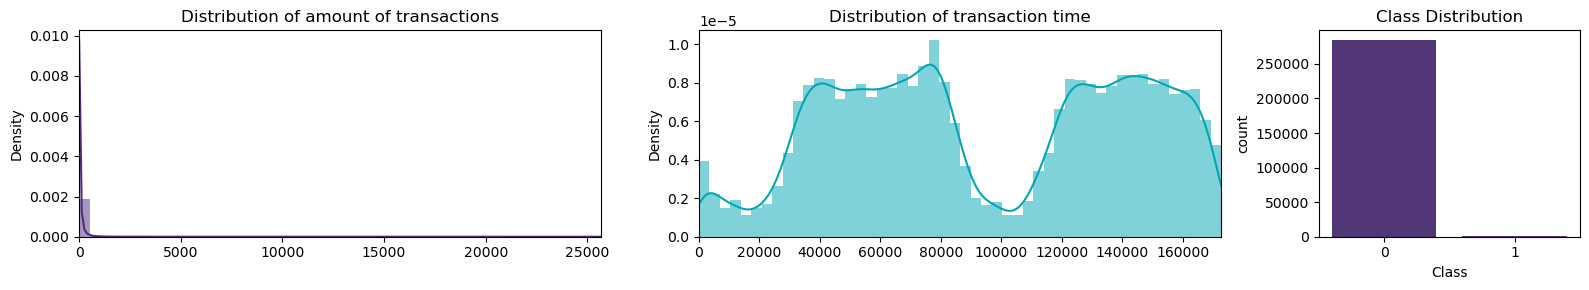

In [4]:
fig, axs = plt.subplots(1, 3, gridspec_kw={"width_ratios": [2, 2, 1]}, figsize=(16, 3))

sns.histplot(df["Amount"].values, ax=axs[0], kde=True, bins=50, stat="density", linewidth=0, color=color_palette[0])
axs[0].set_title("Distribution of amount of transactions", fontsize=12)
axs[0].set_xlim([min(df["Amount"].values), max(df["Amount"].values)])

sns.histplot(df["Time"].values, ax=axs[1], kde=True, bins=50, stat="density", linewidth=0, color=color_palette[1])
axs[1].set_title("Distribution of transaction time", fontsize=12)
axs[1].set_xlim([min(df["Time"].values), max(df["Time"].values)])

sns.countplot(data=df, x="Class", color=color_palette[0], ax=axs[2])
axs[2].set_title("Class Distribution", fontsize=12)


fig.tight_layout()
plt.show()

From the distribution it can be identified that the transaction amount follows an exponential type pattern. The transaction time follows a time series pattern but not sufficient enough to derive a seasonal trend from it. Further, we also visualized the imballance between fraud cases and normal transactions.

To highlight the impact of an imballanced data set we will use a a correlation matrix for the features. In the first step, the correlation matrix on the raw data is presented. Then we will leverage a simplified technique called undersampling to show the impact on the correlation.

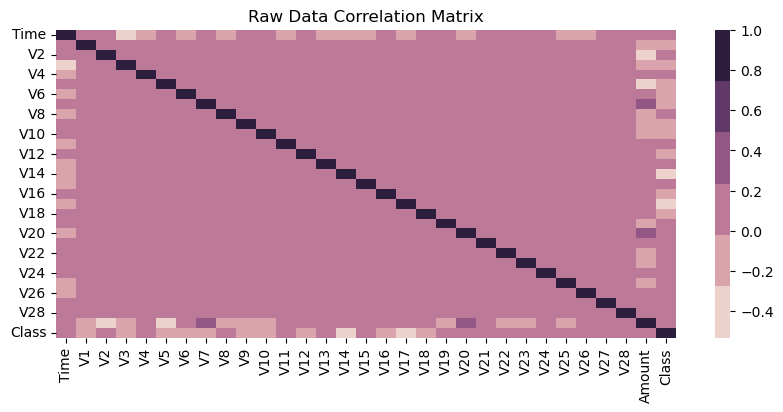

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))

corr = df.corr()
sns.heatmap(corr, cmap=sns.cubehelix_palette(), annot_kws={"size": 20}, ax=ax)
ax.set_title("Raw Data Correlation Matrix", fontsize=12)

plt.show()

The correlation matrix on the raw data indicates that the correlation between the features and our taDrget is not that great between +/- 0.2. 

Next let's balance the data by undersampling. For this, the data set is split into fraud and non-fraud cases. The non-fraud cases are randomly shuffled before sampling the same number of datapoints as we have in the fraud dataset. Then the two datasets are combined. This is a simplified technique to highlight the potential issue of imbalanced data. Later in the pre-processing part we will use a more sophisticated method using the imbalance-learn package. 

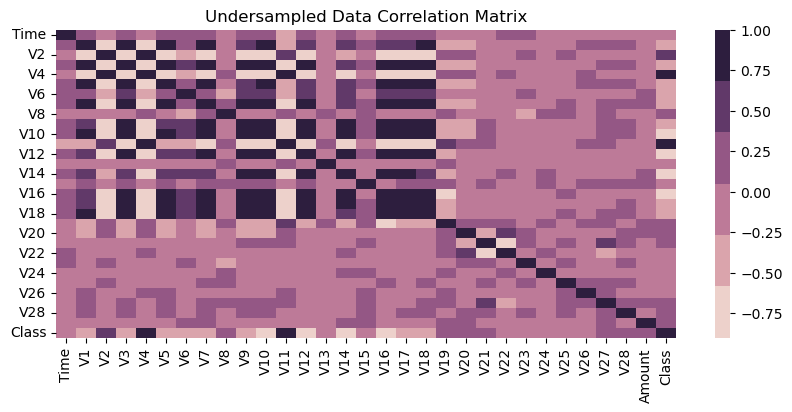

In [6]:
# Filter the fraud cases and get the number of cases.
df_fraud = df[df['Class'] == 1].reset_index(drop=True)
count_fraud = int(len(df_fraud))

# Shuffle the dataframe and sample the non-fraud cases. Frac needs to be 1 to assure we shuffle across the columns.
df_nofraud = df.sample(frac=1)
df_nofraud = df_nofraud.loc[df_nofraud['Class'] == 0][:count_fraud].reset_index(drop=True)

# Combine to create undersampled dataframe
df_under = pd.concat([df_fraud, df_nofraud]).reset_index(drop=True)

# Compute the correlations.
corr = df_under.corr()

# Plot the correlation matrix.
fig, ax = plt.subplots(figsize=(10, 4))

sns.heatmap(corr, cmap=sns.cubehelix_palette(), annot_kws={"size": 20}, ax=ax)
ax.set_title("Undersampled Data Correlation Matrix", fontsize=12)

plt.show()

In [7]:
# Get the highest ranking correlations, return the names and remove the "Class" group.
corr_val = corr[(corr["Class"] >= 0.5) | (corr["Class"] <= -0.5)]["Class"]
corr_features = corr_val.index.tolist()
corr_features.remove("Class") 
print(corr_features)

['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']


The correlation of the undersampled dataset changed and correlation values increased for some features to greater than 0.5. Additionally, we can abstract the correlation values that are large enough and return the features that have generally the best correlation.

These features can be explored further. For this we will use box plots. Generally, box plots are a good visualization method to create understanding of the data spread, highlight potential outliers and compare different features together. the box of the chart describes the lower (25%) quartile, upper (75%) quartile as well as the median. The so called whiskers indiciate minimum and maximum values. Dots outside of the whiskers are outliers based on a normal distribution.

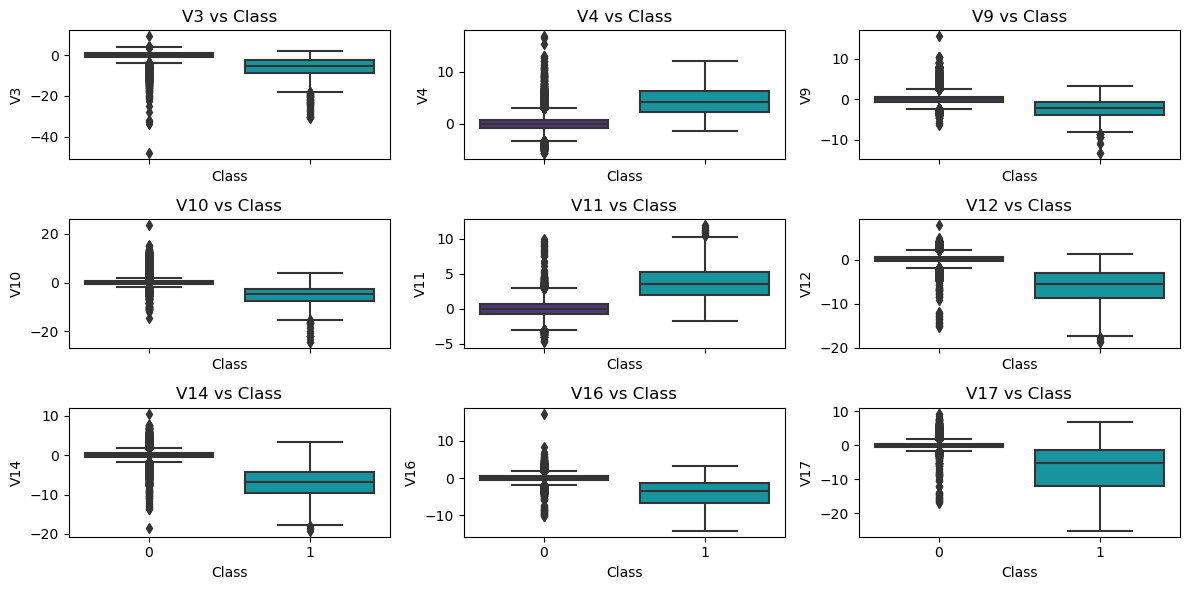

In [8]:
# Plot the boxplots of the featuers with the class.
fig, axs = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(12, 6))

sns.boxplot(data=df, x="Class", y="V3", palette=color_palette, ax=axs[0, 0])
axs[0, 0].set_title("V3 vs Class")

sns.boxplot(data=df, x="Class", y="V4", palette=color_palette, ax=axs[0, 1])
axs[0, 1].set_title("V4 vs Class")

sns.boxplot(data=df, x="Class", y="V9", palette=color_palette, ax=axs[0, 2])
axs[0, 2].set_title("V9 vs Class")


sns.boxplot(data=df, x="Class", y="V10", palette=color_palette, ax=axs[1, 0])
axs[1, 0].set_title("V10 vs Class")

sns.boxplot(data=df, x="Class", y="V11", palette=color_palette, ax=axs[1, 1])
axs[1, 1].set_title("V11 vs Class")

sns.boxplot(data=df, x="Class", y="V12", palette=color_palette, ax=axs[1, 2])
axs[1, 2].set_title("V12 vs Class")


sns.boxplot(data=df, x="Class", y="V14", palette=color_palette, ax=axs[2, 0])
axs[2, 0].set_title("V14 vs Class")

sns.boxplot(data=df, x="Class", y="V16", palette=color_palette, ax=axs[2, 1])
axs[2, 1].set_title("V16 vs Class")

sns.boxplot(data=df, x="Class", y="V17", palette=color_palette, ax=axs[2, 2])
axs[2, 2].set_title("V17 vs Class")

plt.tight_layout()
plt.show()

After evaluating the boxplots we can consider removing some outliers at the cost of reducing the size of the dataset. Most outlier removal techniques take assumptions on the data and it's distribution to set out criteria at which we can remove individual datapoints. However, in this example we will acknowledge the outlier without removing any. A common approache for outlier removal is interquartile range (IQR). Nonetheless, this step should in practice always be considered and discussed since it will often enable higher performance and in some cases a better model generalization. Before removing the outliers a consideration should always be around the stability of the future dataset in production. This is not given in fraud detection because people with malicious intend will always try to find new ways for fradulent behaviour. Additionally, over the recent period we had customer behaviour shift among the many crysis leading to a different "normal" behaviour. 

## Pre-Processing

After having explored and understood the charcteristics of the datasets and potential challenges for the modelling, we can start preparing the data to train the model. First we will apply a scaler on the numeric datasets for transaction amount and transaction time. Based on the previous analysis we will apply a robust scaler since it is less impacted by outlier data. After that we will split the data in training and validation. The validation data will be used at the end to evaluate the model on unseen data.

In [9]:
# Set the scaler objects
robust_scaler = RobustScaler()

df['Amount_scaled'] = robust_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time_scaled'] = robust_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

Next, we split the data into training and validation. For this we will use a the cross validation method Stratified-K-Fold, returning the stratified folds of the training and validation data.

In [10]:
X = df.drop("Class", axis=1)
y = df["Class"]

# Create the stratified kfold object.
stratified_k = StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

for train_ix, val_ix in stratified_k.split(X, y):
    actual_X_train, actual_X_val = X.iloc[train_ix], X.iloc[val_ix]
    actual_y_train, actual_y_val = y.iloc[train_ix], y.iloc[val_ix]

# We convert the values into arrays for the model.
actual_X_train = actual_X_train.values
actual_X_val = actual_X_val.values
actual_y_train = actual_y_train.values
actual_y_val = actual_y_val.values

# See if both the train and test label distribution are similarly distributed
train_unique, train_counts = np.unique(actual_y_train, return_counts=True)
val_unique, val_count = np.unique(actual_y_val, return_counts=True)

print("Label distributions after split:")
print("-" * 100)
print("Train: ", np.around(train_counts / len(actual_y_train), 4))
print("Test:  ", np.around(val_count / len(actual_y_val), 4))
print("-" * 100)
print(f"Length of X values used for training: {len(actual_X_train)} | Length of y values used for training: {len(actual_y_train)}")
print(f"Length of X values used for validation: {len(actual_X_val)} | Length of y values used for validation: {len(actual_y_val)}")
print("-" * 100)

Label distributions after split:
----------------------------------------------------------------------------------------------------
Train:  [0.9983 0.0017]
Test:   [0.9983 0.0017]
----------------------------------------------------------------------------------------------------
Length of X values used for training: 227846 | Length of y values used for training: 227846
Length of X values used for validation: 56961 | Length of y values used for validation: 56961
----------------------------------------------------------------------------------------------------


## Model Build and Evaluation

A random forest classifier is used for the fraud detection. The random forest classifier is an ensemble model, combining multiple prediction trees with random sampling. Generally, random forests produce of the box great accuracy. Nonetheless, you should experiment with models yourself to identify the most suitable option for your use case.

For the model evaluation, we will focus on the F1-Score as performance metric. However, it is good practice to evaluate and understand multiple performance metrics to get understanding of the limitiation of the models capability. 

In the following the random forest classifier is set and a parameter dictionary is defined which will later used for hyperparameter tuning of the classifier. 

In [11]:
# Generate lsits that will be populated in the loop.
accuracies = []
precisions = []
recalls = []
f1s = []
aucs = []

# Set the hyperparamter parameters.
params_dict = {
    "n_estimators": [int(x) for x in np.linspace(start=10, stop=50, num=10)],
    "max_features": ["sqrt", "log2"],
    "max_depth": [2, 4],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False]
}

# Set the classifier and the hyperparameters.
clf = RandomForestClassifier()
rand_clf = RandomizedSearchCV(clf, params_dict, n_iter=3)

Then, the stratified-k-fold is applied again to generate folds of the training and model testing data. It is important to understand that the testing data is not the same as the validation data. Validation contains data the model has not seen which had been witheld until the end to test the best model after hyperparameter optimization. With that in mind we build the model pipeline using a method to augment the fraud cases called synthetic minority oversampling technique (SMOTE). We can use this method as part of the imbalanced-learn package to oversample imbalanced classification data sets. As the name states we generate a synthetic data set by oversampling the examples of fraud cases and creating a bigger data set then we actually have.  

In [12]:
# SMOTE with cross-validation.
stratified_k = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
print("Start SMOTE and cross-validation.")
print("-" * 100, "\n")
for train_ix, test_ix in stratified_k.split(actual_X_train, actual_y_train):
    print(f"     Length training {len(train_ix)} | Length testing {len(test_ix)}.")
    print(f"     [x] Generating pipeline and training model.")
    pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), rand_clf)
    print(f"     [x] Pipeline built sucessfull.")
    model = pipeline.fit(actual_X_train[train_ix], actual_y_train[train_ix])
    print(f"     [x] Model training sucessfull.")
    selected_estimator = rand_clf.best_estimator_
    print(f"     [x] Selected best estimator model.")
    
    # Generate the predictions with best estimator.
    predictions = selected_estimator.predict(actual_X_train[test_ix])
    print(f"     [x] Generated predictions")
    
    precisions.append(precision_score(actual_y_train[test_ix], predictions))
    recalls.append(recall_score(actual_y_train[test_ix], predictions))
    f1s.append(f1_score(actual_y_train[test_ix], predictions))
    aucs.append(roc_auc_score(actual_y_train[test_ix], predictions))

    print(f"     [x] Computed performance")
    print("-" * 100, "\n")
    
print('---' * 50, "\n")
print(f"Overall precision:  {round(np.mean(precisions), 3)}")
print(f"Overall recall:     {round(np.mean(recalls), 3)}")
print(f"Overall F1:         {round(np.mean(f1s), 3)}", "\n")
print('---' * 50)



Start SMOTE and cross-validation.
---------------------------------------------------------------------------------------------------- 

     Length training 170884 | Length testing 56962.
     [x] Generating pipeline and training model.
     [x] Pipeline built sucessfull.
     [x] Model training sucessfull.
     [x] Selected best estimator model.
     [x] Generated predictions
     [x] Computed performance
---------------------------------------------------------------------------------------------------- 

     Length training 170884 | Length testing 56962.
     [x] Generating pipeline and training model.
     [x] Pipeline built sucessfull.
     [x] Model training sucessfull.
     [x] Selected best estimator model.
     [x] Generated predictions
     [x] Computed performance
---------------------------------------------------------------------------------------------------- 

     Length training 170885 | Length testing 56961.
     [x] Generating pipeline and training model.
     [x]

In [13]:
labels = ['No Fraud', 'Fraud']
final_predictions = selected_estimator.predict(actual_X_val)

print(classification_report(actual_y_val, final_predictions, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56863
       Fraud       0.40      0.82      0.54        98

    accuracy                           1.00     56961
   macro avg       0.70      0.91      0.77     56961
weighted avg       1.00      1.00      1.00     56961



On the validation data the model achieved an F1 score of TK. This can further be improved by changing some of the assumptions and steps we had taken. 

A first step to achieve better performance is by looking into outlier events among the V1-12 features. While this may certainly improve accuracy in the training it might cause problems when deploying in production, so good outlier handling needs to be thought through from use-case to deployment. Another option is to train and compare more than one model. Then, the hyperparamter tuning can be broadenend and tweaks or tweaking the assumptions for Startified-K-Fold and SMOTE. 

Another avenue that was not explored in this article is the feature engineering. However, this would require context around the available features. In a real world application it is always worthwhile combining, calculating or deriving new features from the existing one. 

Latsly, we could look into the data size. More data can improve the model by exposing longer term trends that are not captured within a month. 

## Summary

In this article we trained a random forest classifier on anonimized credit card data from Kaggle. We explored the aspects of imbalanced data and how to circumvent it using SMOTE. 

 Well not exactly. Producing the model was one part. Now the work starts in translating it into a business value and laying the path to integrate it into a platform. If you want to learn more on how to get started with your first data science use case and translate it into a model get in touch with our GTLab.

Another consideration is that this use case example would be hard to be translated into production. Considering we only have one month of data available the true historical transaction number will be much higher. September is not a special period in Europe not including holidays or anything. The actual number of transaction over the year will be in the millions. The models would also be trained on heeps of historical data 